Here’s the same “explain-like-I’m-5-but-useful” tour 👇

# What is UCB (Upper Confidence Bound)?

A strategy for **choosing between options while learning** (the “multi-armed bandit” problem).
Rule of thumb: **“Try the thing that looks best, plus a bonus for uncertainty.”**
That bonus makes you **explore** options you don’t know well yet, instead of getting stuck too early.

Think shopkeeper problem: you can feature **one** product at the top of your homepage each visit. You see if it gets a click/buy (reward), then immediately pick again for the next visitor. Which product should you show **today** while still learning?

---

# Core formula (UCB1)

For each option (arm) (i) at round (t):

[
\text{UCB}_i(t) ;=; \overline{r}_i ;+; \sqrt{\frac{2\ln t}{n_i}}
]

* (\overline{r}_i): current **average reward** for option (i) (e.g., click-through rate), using what you’ve seen so far.
* (n_i): how many times you tried option (i).
* (t): total number of trials so far (1,2,3,…)
* The second term is the **exploration bonus**: big when (n_i) is small (we’re unsure), and it **shrinks** as we try (i) more.

> Reward should be **bounded** in ([0,1]) (e.g., click = 1, no click = 0). If not, **scale** it.

---

# Step-by-step guide (shop example)

**Goal:** pick among 3 banners (A, B, C) for each visitor to maximize clicks.
**Reward:** click = 1, no click = 0.
**Plan:** start by trying each banner once, then use UCB formula forever after.

### Step 0 — Initialize

* Set (\overline{r}_A=\overline{r}_B=\overline{r}_C=0), (n_A=n_B=n_C=0), (t=0).

### Step 1 — Try each option once (warm-up)

* Round 1: show A → say user clicked → reward 1.
  Update: (n_A=1, \overline{r}_A=1.0, t=1).
* Round 2: show B → no click → reward 0.
  Update: (n_B=1, \overline{r}_B=0.0, t=2).
* Round 3: show C → click → reward 1.
  Update: (n_C=1, \overline{r}_C=1.0, t=3).

### Round 4 — Compute UCBs, pick the max

Use (\text{UCB}=\overline{r}+\sqrt{\tfrac{2\ln t}{n}}) with (t=4) (and (\ln 4\approx1.386)):

* A: (1.0 + \sqrt{(2\cdot1.386)/1} \approx 1.0 + 1.665 = 2.665)
* B: (0.0 + 1.665 = 1.665)
* C: (1.0 + 1.665 = 2.665)

Pick the **largest** (tie → break arbitrarily). Suppose we choose **A**.

Assume Round 4 reward for A = 0 (no click).
Update: (n_A=2,; \overline{r}_A=(1+0)/2=0.5,; t=4\to5).

### Round 5 — Recompute & pick again

Now (t=5) ((\ln 5\approx1.609)):

* A: (0.5 + \sqrt{(2\cdot1.609)/2} = 0.5 + \sqrt{1.609} \approx 0.5 + 1.269 = 1.769)
* B: (0.0 + \sqrt{3.218} \approx 1.793)
* C: (1.0 + 1.793 = 2.793)

Pick **C** (largest). Suppose C clicks (reward 1):
Update: (n_C=2,; \overline{r}_C=(1+1)/2=1.0,; t=5\to6).

### Keep going…

As (n_i) grows, the bonus **shrinks** for well-explored options.

* A and C have decent knowledge now, so B (still uncertain) will periodically get pulled **up** by its larger bonus and be tested again.
* Over time, UCB balances **exploration** (try B sometimes) with **exploitation** (mostly show the best-looking banner).

---

# Why UCB works (intuitively)

* It’s **optimistic under uncertainty**: give each option the benefit of the doubt, proportional to how little we know about it.
* If an option is truly worse, its average won’t improve, and the bonus shrinks → it gets chosen less and less.
* If an option is secretly good, its bonus keeps it in play until we learn that its average reward is high.

---

# Pseudocode (UCB1)

```
Input: K arms, horizon T
Play each arm once:
  for i in 1..K:
    r = pull(i)                   # 0/1 reward (or scaled to [0,1])
    n[i] = 1
    avg[i] = r
t = K
Loop t = K+1..T:
  for i in 1..K:
    ucb[i] = avg[i] + sqrt( (2*ln(t)) / n[i] )
  a = argmax_i ucb[i]
  r = pull(a)
  n[a] += 1
  avg[a] = avg[a] + (r - avg[a]) / n[a]   # incremental mean update
```

---

# Python (minimal, ready to paste)

```python
import math
import random

def ucb1(arms, T):
    """
    arms: list of callables returning a reward in [0,1], e.g., lambda: random.random() < 0.12
    T: number of rounds
    """
    K = len(arms)
    n = [0]*K
    avg = [0.0]*K
    history = []

    # warm-up: play each arm once
    for i in range(K):
        r = arms[i]()
        n[i] = 1
        avg[i] = r
        history.append((i, r))

    for t in range(K+1, T+1):
        ucb = [avg[i] + math.sqrt((2.0*math.log(t))/n[i]) for i in range(K)]
        a = max(range(K), key=lambda i: ucb[i])
        r = arms[a]()
        n[a] += 1
        avg[a] += (r - avg[a]) / n[a]
        history.append((a, r))
    return n, avg, history

# Example: true click probs for A,B,C
random.seed(42)
arms = [
    lambda: 1.0 if random.random() < 0.08 else 0.0,  # A: 8% CTR
    lambda: 1.0 if random.random() < 0.05 else 0.0,  # B: 5% CTR
    lambda: 1.0 if random.random() < 0.12 else 0.0,  # C: 12% CTR (best)
]
n, avg, hist = ucb1(arms, T=5000)
print("Plays:", n)          # should heavily favor arm 3 over time
print("Estimated CTRs:", avg)
```

---

# When to use UCB (and how)

**Use UCB when you:**

* Make **repeated choices** with **immediate feedback** (click, signup, sale).
* Want a **single best** option (A/B/n) while still learning.
* Expect **stationary** rewards (probabilities don’t drift much hour-to-hour).

**Examples in a shop/site:**

* Which **banner** to show (CTR/CR as reward).
* Which **coupon** or **price** to offer (profit scaled to [0,1]).
* Which **recommendation slot** item to place (click/buy as reward).

**How to deploy:**

1. Define arms (variants).
2. Define reward in **[0,1]** (e.g., click=1/no=0; or profit scaled by a known max).
3. Start live traffic with UCB.
4. Log **(arm, reward, timestamp)**.
5. Monitor: cumulative reward, per-arm estimates, exploration rate.

---

# Variants & practical notes

* **Exploration scale (c):** some use (\overline{r} + c\sqrt{\frac{\ln t}{n}}). Larger (c) = more exploration.
* **UCB-Tuned:** adjusts the bonus using variance estimates (often better when rewards vary).
* **Non-stationary rewards:** use **sliding-window UCB** or **discounted UCB** (recent data counts more).
* **Context matters?** If the “best” option depends on features (device, time, user), use **contextual bandits** (e.g., **LinUCB**).
* **Delayed rewards:** UCB assumes quick feedback; if delayed, queue updates carefully.
* **Scaling:** if rewards aren’t naturally in ([0,1]), **normalize** by a safe max.

---

# Quick cheat sheet

* **Rule:** pick option with **(current average) + (uncertainty bonus)**.
* **Bonus shrinks** as you sample more → automatic explore/exploit balance.
* **Great for online A/B/n** with immediate, bounded rewards.
* Use **UCB1** first; consider **UCB-Tuned** or **contextual** versions as needs grow.



# Upper Confidence Bound (UCB)

## Importing the libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Importing the dataset

In [0]:
dataset = pd.read_csv('Ads_CTR_Optimisation.csv')

## Implementing UCB

In [0]:
import math
N = 10000
d = 10
ads_selected = []
numbers_of_selections = [0] * d
sums_of_rewards = [0] * d
total_reward = 0
for n in range(0, N):
    ad = 0
    max_upper_bound = 0
    for i in range(0, d):
        if (numbers_of_selections[i] > 0):
            average_reward = sums_of_rewards[i] / numbers_of_selections[i]
            delta_i = math.sqrt(3/2 * math.log(n + 1) / numbers_of_selections[i])
            upper_bound = average_reward + delta_i
        else:
            upper_bound = 1e400
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            ad = i
    ads_selected.append(ad)
    numbers_of_selections[ad] = numbers_of_selections[ad] + 1
    reward = dataset.values[n, ad]
    sums_of_rewards[ad] = sums_of_rewards[ad] + reward
    total_reward = total_reward + reward

## Visualising the results

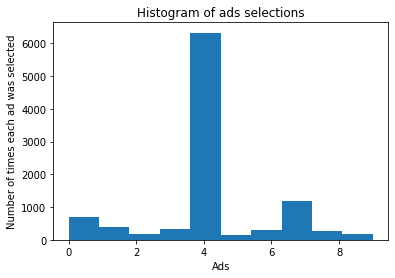

In [4]:
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()